In [7]:
import numpy as np
x = 1.0
print(x)
print(x/3)

1.0
0.3333333333333333


In [1]:
from dataset import read_loss_file, plot_dual_axis
from config import *

train_loss_lst = read_loss_file(train_loss_log_path)
val_loss_lst = read_loss_file(val_loss_log_path)
train_loss_mse_lst = read_loss_file(train_loss_mse_log_path)
val_loss_mse_lst = read_loss_file(val_loss_mse_log_path)
train_loss_bpp_lst = read_loss_file(train_loss_bpp_log_path)
val_loss_bpp_lst = read_loss_file(val_loss_bpp_log_path)

# loss list plot이미지 저장
plot_dual_axis(train_loss_lst, val_loss_lst, mode="all_loss")
plot_dual_axis(train_loss_mse_lst, val_loss_mse_lst, mode="mse_loss")
plot_dual_axis(train_loss_bpp_lst, val_loss_bpp_lst, mode="bpp_loss")

graph saved: graph/loss_plot_all_loss_20250611_132301.png
graph saved: graph/loss_plot_mse_loss_20250611_132301.png
graph saved: graph/loss_plot_bpp_loss_20250611_132301.png


<class 'astropy.io.fits.hdu.image.PrimaryHDU'>


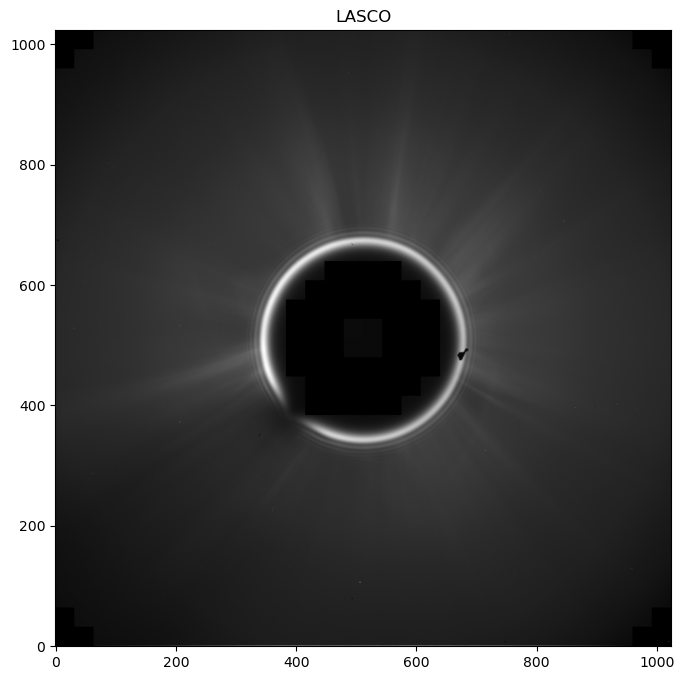

SIMPLE  =                    T / Written by IDL:  Sat May 20 04:34:01 2000      
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 1024 /                                                
NAXIS2  =                 1024 /                                                
FILENAME= '22061347.fts'       /                                                
FILEORIG= '000207_060855.img'  /                                                
DATE    = '2000/05/20 08:33:52.983' /                                           
DATE-OBS= '2000/02/07'         /                                                
TIME-OBS= '06:06:06.208'       /                                                
P1COL   =                   20 /                                                
P1ROW   =                    1 /                                                
P2COL   =                 10

In [17]:
from config import *
import os
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import torch

f = open(data1024_filename,'r')
data1024lst = [line.strip() for line in f.readlines()]

path1 = os.path.join(PATH,data1024lst[100])
image_data1 = fits.open(path1)
print(type(image_data1[0]))

img = image_data1[0].data
plt.figure(figsize=(12,8))
plt.imshow(img, cmap='gray', origin='lower')
plt.title('LASCO')
# plt.colorbar()
plt.show()

image_data1[0].header

# img_512 = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
# plt.imshow(img_512, cmap='gray')
# plt.title('Resized Image to 512x512')
# plt.colorbar()
# plt.show()

# img = img.astype(img.dtype.newbyteorder('='))
# img_torch_resized = transforms.ToTensor()(img)
# img_torch_resized = transforms.Resize((512, 512))(img_torch_resized)
# img_torch_resized = img_torch_resized.numpy()[0]
# plt.imshow(img_torch_resized, cmap='gray')
# plt.title('Torch Resized Image to 512x512')
# plt.colorbar()
# plt.show()

In [1]:
from dataset import get_datasets
from transforms import get_test_transform
from compressai.zoo import cheng2020_attn
from torch.utils.data import DataLoader
from metric import calculate_ms_ssim, calculate_psnr
import torch

data1024_filename = 'data1024lst.txt'
transform = get_test_transform()
device = torch.device('cuda:2')

model_pt = cheng2020_attn(pretrained=True, quality=6).to(device).eval()

model_ft = cheng2020_attn(pretrained=False, quality=6).to(device)
model_ft.load_state_dict(torch.load("best_model.pth"))
model_ft.eval()

_, _, test_set = get_datasets(data1024_filename, transform=transform)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [2]:
from config import *
import time
import os
import matplotlib.pyplot as plt

def read_loss_file(filepath):
    losses = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                losses.append(float(line.strip()))
    return losses

def plot_dual_axis(train_losses, val_losses, save_path='loss_dual_axis.png', save = True):
    # 파일 이름에 타임스탬프 추가
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    name, ext = os.path.splitext(save_path)
    save_path = f"{name}_{timestamp}{ext}"

    epochs = list(range(len(train_losses)))

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 오른쪽 y축 - Train Loss
    ax1.set_ylabel('Train Loss', color='tab:blue')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:blue', marker='o', alpha = 0.2, markersize = 6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 왼쪽 y축 - Validation Loss
    ax2 = ax1.twinx()  # ax1과 x축 공유, y축만 따로
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss', color='tab:red')
    ax2.plot(epochs, val_losses, label='Validation Loss', color='tab:red', marker='o', alpha = 0.2, markersize = 6)
    ax2.tick_params(axis='y', labelcolor='tab:red')



    # 제목 및 저장
    plt.title('Training vs Validation Loss (Dual Y-Axis)')
    fig.tight_layout()  # 여백 자동 조정
    if save:
        plt.savefig(save_path)
        print(f"그래프 저장 완료: {save_path}")
    else:
        plt.show()
    plt.close()
    

# 저장된 loss list 가져오기
train_loss_lst = read_loss_file(train_log_path)
val_loss_lst = read_loss_file(val_log_path)
# loss list plot이미지 저장
plot_dual_axis(train_loss_lst, val_loss_lst, save=True)

그래프 저장 완료: loss_dual_axis_20250523_184857.png


In [23]:
import os

def count_all_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count


print(count_all_files("./data/CME_unpiped"))

20708


In [1]:
# data split, model choise, GPU setting
from sklearn.model_selection import train_test_split
from compressai.zoo import cheng2020_attn
import torch
import os
from torchvision import transforms
from compressai.losses import RateDistortionLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import astropy.io.fits as fits
import numpy as np
import math
import time

# data 읽어오기
data1024_filename = 'data1024lst.txt'

f = open(data1024_filename,'r')
data1024copy = [line.strip() for line in f.readlines()]
print(len(data1024copy))

torch.cuda.empty_cache()

# train:val:test = 7:1:2
X_train, X_test = train_test_split(data1024copy, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size =1/8, random_state=42)

PATH = "/nas/userdata/kim_y/CME autodetection/LZ/CME_unpiped/"

# GPU 사용
device = torch.device('cuda:1')

# quality=6 → 논문에서 사용한 lambda=0.0483에 해당
model = cheng2020_attn(pretrained=True, quality=6).train().to(device)

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())


20624
Device: cuda:1
Current cuda device: 0
Count of using GPUs: 4


In [2]:
# main
# <전제>
# 논문에서의 전처리는 16bit정수형 -> 8bit정수형 byte scale
# 모델도 8bit정수형으로 양자화 되어야 하는가? 해석의 모호함 존재
# -> 우선 전처리에서 byte scale은 빼고 진행

# loss함수 정의가 모델의 입력 출력의 값 범위가 [0,255]인것이 전제이다.
# 그에 맞춰 모델의 입력 출력 데이터를 처리한다.
# -> 이렇게 하니 모델 출력이 발산하는 문제 발생
# 다시 입력 범위 [0,1]로 맞춤
# loss의 distortion에 곱해진 255^2을 없앰

# 학습속도 너무 느림, 1epoch가 2시간 걸림;
# 이미지 사이즈 256 by 256 으로 resize 함
# batch size = 16

log_max = 0
log_min = 0

def cut_saturation(img_arr, threshold=3):
    pixels = img_arr.flatten()
    pmean = np.mean(pixels)
    pstd = np.std(pixels)  
    pmax = threshold*pstd + pmean 
    modified_array = np.where(img_arr > pmax, pmax, img_arr)
    return modified_array

def minmax(img_arr):
    global log_max
    global log_min 
    log_max = torch.max(img_arr)
    log_min = torch.min(img_arr)
    byteimage = ((img_arr - log_min) / (log_max - log_min))
    return byteimage

def rescale(img_arr):
    global log_max
    global log_min 
    rescaled_img = img_arr * (log_max - log_min) + log_min
    return rescaled_img

# 사용자 정의 Dataset 클래스 생성
class ImageDataset(Dataset):
    def __init__(self, img_dir, data_name_lst, transform=None):
        self.img_dir = img_dir
        self.img_labels = data_name_lst 
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = fits.open(img_path)[0].data
        if self.transform:
            image = self.transform(image)
        return image
    

transform = transforms.Compose([
    # ValueError: given numpy array has byte order different from the native byte order. 
    # Conversion between byte orders is currently not supported.
    # 위의 에러 해결 위해 numpy int16을 float32로 바꿔주는 코드 추가
    lambda img: img.astype(np.float32), # byte
    transforms.ToTensor(),
    transforms.Resize((256,256)), 
    lambda img: torch.clamp(img, min=0),
    # log conversion
    lambda img: torch.log1p(img), # [log_min, log_max]
    minmax, # [0,1] 
    lambda img: torch.Tensor.repeat(img,3,1,1).type(torch.float)
])

invtransform = transforms.Compose([
    lambda img: img.squeeze(0).permute(1, 2, 0),
    # numpy로 바꾸기 전에 max값으로 나누고 mean때리고 exmp1하는게 더 빠르지 않을까
    lambda img: img.mean(axis=2),
    # inverse byte scale
    lambda img: img/torch.max(img), # [0,1]
    rescale, # [log_min, log_max]
    # invers log conversion
    lambda img: torch.expm1(img)# [0, max]
])



class CustomRateDistortionLoss(RateDistortionLoss):
    def forward(self, output, target):
        # 기존 클래스의 일부는 유지하되, distortion 항만 수정
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )
        
        # 수정: 255^2 제거
        out["mse_loss"] = self.metric(output["x_hat"], target)
        distortion = out["mse_loss"]

        out["loss"] = self.lmbda * distortion + out["bpp_loss"]
        return out

# variable setting
batch_size = 16
learning_rate = 1e-4
patience = 15 # max patience
j = 0 # current patience
epoch = 0 
criterion = CustomRateDistortionLoss(lmbda=0.0483)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_workers = 0

# dataset
image_trainset = ImageDataset(PATH, X_train,transform=transform)
train_loader = DataLoader(image_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)

image_valset = ImageDataset(PATH, X_val,transform=transform)
val_loader = DataLoader(image_valset, batch_size=batch_size, shuffle=False, pin_memory=True)

image_testset = ImageDataset(PATH, X_test,transform=transform)
test_loader = DataLoader(image_testset, shuffle=False, pin_memory=True)

train_loss_lst = []
val_loss_lst = []

num_epochs = 100
best_val_loss = 100
for epoch in range(num_epochs):
    model.train()  # 학습 모드로 설정
    train_loss = 0.0
    for i, inputs in enumerate(train_loader):
        t0 = time.time()
        optimizer.zero_grad() # 이전 iteration의 gradient 0으로 

        inputs =inputs.to(device, non_blocking = True)
        t1 = time.time()
        # 순전파 (Forward pass)
        outputs = model(inputs)
        t2 = time.time()
        loss = criterion(outputs, inputs)
        t3 = time.time()
        # 역전파 및 파라미터 업데이트
        loss['loss'].backward() # gradient 계산
        t4 = time.time()
        optimizer.step() # gradient 통해 model 업데이트
        t5 = time.time()
        train_loss += loss['loss'] * inputs.size(0)
        t6 = time.time()
        if i%10 == 0:
            print("epoch",epoch+1,"/ iteration:",i,", ratio:",round((i+1)/len(train_loader)*100,2),"%", "train_loss:",round((train_loss/(batch_size*(i+1))).item(),6))
            print(f"[{i}] Data load: {t1-t0:.3f}s | Forward: {t2-t1:.3f}s | loss calc: {t3-t2:.3f}s | gradient calc: {t4-t3:.3f}s | update: {t5-t4:.3f}s | lst_append: {t6-t5:.3f}s")
    train_loss /= len(X_train)
    train_loss_lst.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # 검증 루프
    model.eval()  # 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():
        for inputs_val in val_loader:

            inputs_val =inputs_val.to(device, non_blocking = True)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, inputs_val)
            loss_val['loss'] = criterion.lmbda*loss_val['mse_loss'] + loss_val['bpp_loss']
            # loss_val['loss'].backward()
            val_loss += loss_val['loss'] * inputs_val.size(0)
        val_loss /= len(X_val)
        val_loss_lst.append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Early Stopping 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            j = 0
            torch.save(model.state_dict(), 'best_model.pth') # Best 모델 저장
        else:
            j += 1
            if j >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

epoch 1 / iteration: 0 , ratio: 0.11 % train_loss: 0.208895
[0] Data load: 0.002s | Forward: 0.599s | loss calc: 0.096s | gradient calc: 0.318s | update: 0.107s | lst_append: 0.000s


KeyboardInterrupt: 

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

In [3]:
# data 읽어오기
data1024_filename = 'data1024lst.txt'
data512_filename = 'data512lst.txt'

f = open(data512_filename,'r')
data512copy = [line.strip() for line in f.readlines()]
print(data512copy)
print(len(data512copy))

f = open(data1024_filename,'r')
data1024copy = [line.strip() for line in f.readlines()]
print(data1024copy)
print(len(data1024copy))

['20000415_100606.fts', '20000422_033412.fts', '20020514_211725.fts', '20030108_174802.fts', '20030108_183910.fts', '20030108_193023.fts', '20030121_212105.fts', '20030130_093915.fts', '20030130_100605.fts', '20030130_103914.fts', '20030130_110605.fts', '20030130_113914.fts', '20030130_120605.fts', '20030218_030807.fts', '20030126_110605.fts', '20030129_043935.fts', '20030130_123915.fts', '20030216_224205.fts', '20030218_020805.fts', '20030218_120805.fts', '20040420_094206.fts', '20040420_100805.fts', '20040420_104207.fts', '20040420_110805.fts', '20040420_114205.fts', '20040420_120805.fts', '20040420_124205.fts', '20040420_140805.fts', '20040420_144207.fts', '20040605_100605.fts', '20040901_144743.fts', '20070331_033411.fts', '20070515_194732.fts', '20070515_203816.fts', '20070515_212853.fts', '20051026_174725.fts', '20051026_183838.fts', '20051026_192938.fts', '20000524_100605.fts', '20060412_194629.fts', '20061025_203915.fts', '20070115_080804.fts', '20120127_034714.fts', '20140103_

<class 'astropy.io.fits.hdu.image.PrimaryHDU'>
Filename: /nas/userdata/kim_y/CME autodetection/LZ/CME_unpiped/19970920_000505.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      80   (1024, 1024)   int16   
None


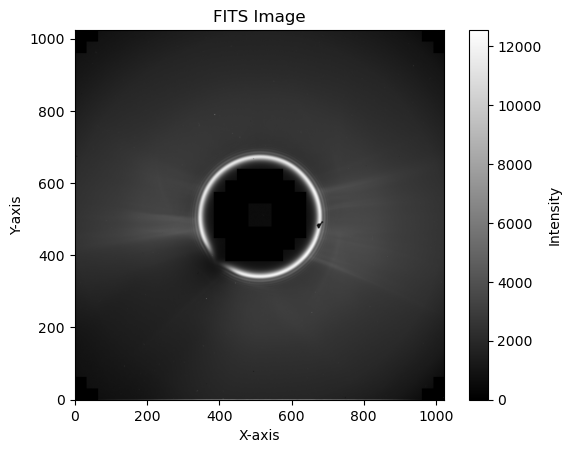

In [4]:
# 임의의 데이터 1장 PLOT
path1 = os.path.join(PATH,data1024copy[0])
image_data1 = fits.open(path1)
print(type(image_data1[0]))
image_data1.info(0)[0][5][0]
img = image_data1[0].data

print(image_data1.info())

plt.figure()
plt.imshow(img, origin='lower', cmap='gray')  # 'gray'는 흑백 컬러맵, origin='lower'는 이미지 축 방향 설정
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('FITS Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [5]:
# 이 셀 실행 안 시켜도 된다.
# 1024 sized와 512size 구분분
# from tqdm import tqdm
# data1024 = []
# data512 = []
# for filename in tqdm(fits_name_lst):
#     filepath = os.path.join(PATH,filename)
#     data = fits.open(filepath)
#     img_size = data.info(0)[0][5][0]
#     if img_size == 1024:
#         data1024.append(filename)
#     elif img_size == 512:
#         data512.append(filename)
#     else:
#         print("error")
#         break

In [6]:
# 이 셀 실행 안 시켜도 된다.
#data 1024, 512 이름 저장, w는 덮어쓰기 모드

# data1024_filename = 'data1024lst.txt'
# data512_filename = 'data512lst.txt'

# w = open(data512_filename,'w')
# for elem in data512:
#     w.write(elem + '\n')
# w.close()

# w = open(data1024_filename,'w')
# for elem in data1024:
#     w.write(elem + '\n')
# w.close()

- data1024: 20624
- data512: 84
- ->data1024만 이용

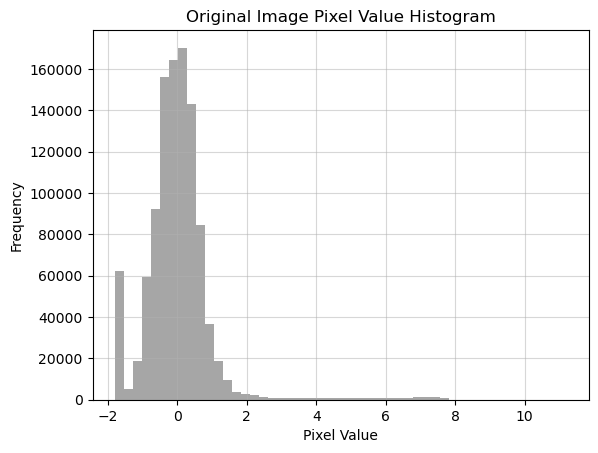

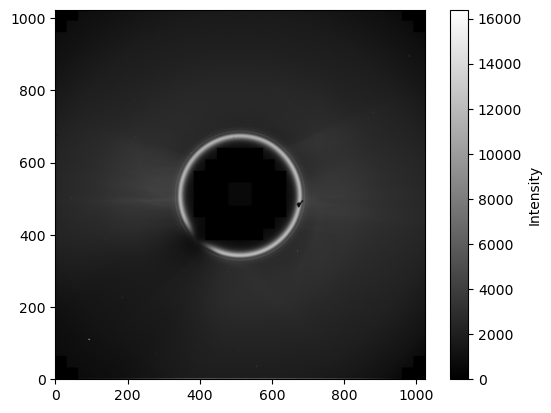

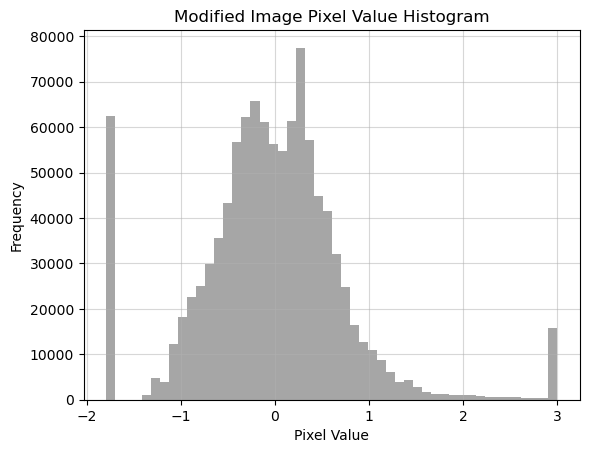

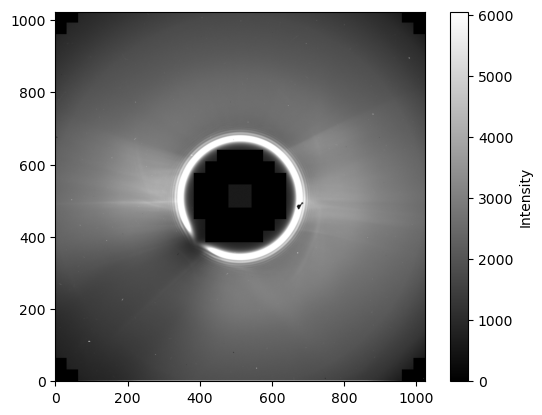

In [7]:
# Pixels value histogram & cut saturation
def cut_saturation(img_arr, threshold = 3):
    pixels = img_arr.flatten()
    pmean = np.mean(pixels)
    pstd = np.std(pixels)  
    pmax = threshold*pstd + pmean 
    modified_array = np.where(img_arr > pmax, pmax, img_arr)
    
    return modified_array

# 이미지 불러오기
path1 = os.path.join(PATH,data1024copy[7])
image_data1 = fits.open(path1)
img_origin = image_data1[0].data
img_array = np.array(img_origin)

# 픽셀 값들을 1차원 배열로 추출
pixels = img_array.flatten()

pmean = np.mean(pixels)
pstd = np.std(pixels)
zpixels = (pixels - pmean)/pstd

# 히스토그램 플롯
plt.figure()
plt.hist(zpixels, bins=50, color='gray', alpha=0.7)

# 플롯 꾸미기 
plt.title('Original Image Pixel Value Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.show()

plt.figure()
plt.imshow(img_array, origin='lower', cmap = 'gray')
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
#######################################################################
# saturation픽셀 자르기
modified_arr = cut_saturation(img_array, threshold=3)

# 픽셀 값들을 1차원 배열로 추출
pixels = modified_arr.flatten()

zpixels = (pixels - pmean)/pstd

# 히스토그램 플롯
plt.figure()
plt.hist(zpixels, bins=50, color='gray', alpha=0.7)

# 플롯 꾸미기 
plt.title('Modified Image Pixel Value Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.show()

plt.figure()
plt.imshow(modified_arr, origin='lower', cmap = 'gray')
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)


In [8]:
# 이미지 한장 pretrained모델에 인풋 및 결과 출력
import torch
from torchvision import transforms
from compressai.zoo import cheng2020_attn
# GPU 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# quality=6 → 논문에서 사용한 lambda=0.0483에 해당
model = cheng2020_attn(pretrained=True, quality=6).eval()
model = model.to(device)

log_max = 0
log_min = 0

def cut_saturation(img_arr, threshold=3):
    pixels = img_arr.flatten()
    pmean = np.mean(pixels)
    pstd = np.std(pixels)  
    pmax = threshold*pstd + pmean 
    modified_array = np.where(img_arr > pmax, pmax, img_arr)
    return modified_array

def minmax(img_arr):
    global log_max
    global log_min 
    log_max = np.max(img_arr)
    log_min = np.min(img_arr)
    byteimage = ((img_arr - log_min) / (log_max - log_min))
    return byteimage

def rescale(img_arr):
    global log_max
    global log_min 
    rescaled_img = img_arr * (log_max - log_min) + log_min
    return rescaled_img

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)), 
])

transform2 = transforms.Compose([
    lambda img: img.numpy(), # [0, max]
    # log conversion
    lambda img: np.log1p(img), # [log_min, log_max]
    # byte scale
    minmax, # [0,1] 
    lambda img: img * 255.0, # [0, 255]
    lambda img: img.astype(np.uint8), # 255 byte scale
    lambda img: img.squeeze(0),
    transforms.ToTensor(),
    lambda img: torch.unsqueeze(img, dim=0),
    lambda img: torch.Tensor.repeat(img,1,3,1,1).to(device)
])

invtransform = transforms.Compose([
    lambda img: img.squeeze(0).permute(1, 2, 0).cpu().numpy(),
    lambda img: img.mean(axis=2),
    # inverse byte scale
    lambda img: img/np.max(img), # [0,1]
    rescale, # [log_min, log_max]
    # invers log conversion
    lambda img: np.expm1(img).astype(np.int16) # [0, max]
])

# 이미지 데이터 불러오기
path1 = os.path.join(PATH,data1024copy[0])
image_data1 = fits.open(path1)
img_origin = image_data1[0].data


# 이미지 픽셀 값 상한 자르기(saturation 자르기)
img_nosat = cut_saturation(img_origin)

# 데이터 전처리
img_prep1 = transform1(img_nosat)
img_prep2 = transform2(img_prep1)

# 모델 입력 및 출력
with torch.no_grad():
    x_hat = model(img_prep2)['x_hat']  # 복원된 이미지

# 아웃풋 역 전처리
x_final = invtransform(x_hat)

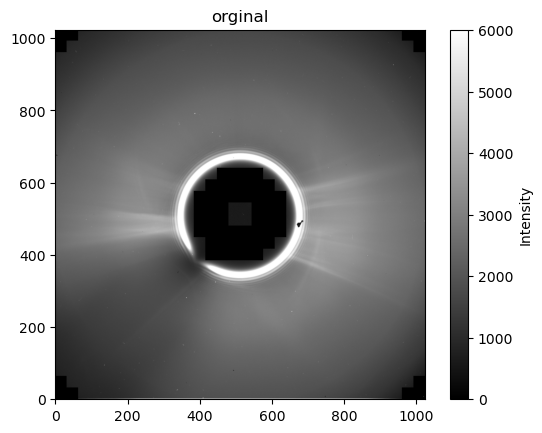

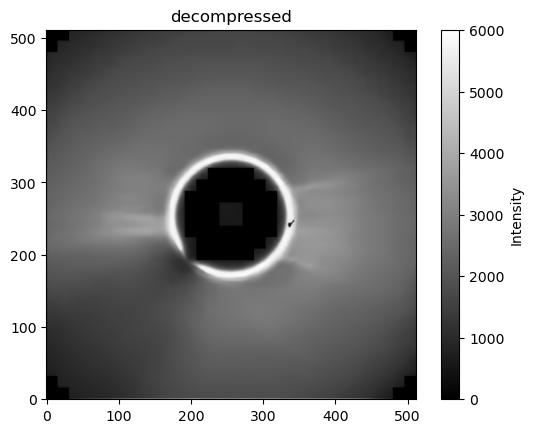

In [9]:
# 이미지 한장 pretrained 모델 결과 비교
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_nosat, origin='lower', cmap = 'gray')
plt.title("orginal")
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)

plt.figure()
plt.imshow(x_final, origin='lower', cmap = 'gray')
plt.title("decompressed")
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)

In [10]:
# MSE, PSNR, SSIM, MS-SSIM
from torch.nn import MSELoss
import math
from skimage.metrics import structural_similarity as ssim
from piq import multi_scale_ssim

def compute_psnr(img1, img2, max_val=32767):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')  # 완벽히 일치할 경우
    return 10 * math.log10((max_val ** 2) / mse), mse

mse_fn = MSELoss()
img_prep1 = img_prep1.squeeze(0)
original_img = img_prep1.numpy()
x_final = x_final.astype(np.float64)

original_img_torch = torch.tensor(original_img, dtype=torch.float32)
predicted_img_torch = torch.tensor(x_final, dtype=torch.float32)

mse = mse_fn(original_img_torch, predicted_img_torch)
psnr,_ = compute_psnr(x_final, original_img)
ssim_score = ssim(original_img,x_final,data_range=32767)

original_img_torch = original_img_torch.unsqueeze(0).unsqueeze(0)
predicted_img_torch = predicted_img_torch.unsqueeze(0).unsqueeze(0)
ms_ssim = multi_scale_ssim(original_img_torch, predicted_img_torch , data_range=32767)

print("MSE:",round(mse.item(),4))
print("PSNR:",round(psnr,4))
print("SSIM:",round(ssim_score,4))
print(f"MS-SSIM: {ms_ssim.item():.4f}")


MSE: 19942.1895
PSNR: 47.311
SSIM: 0.9972
MS-SSIM: 0.9991


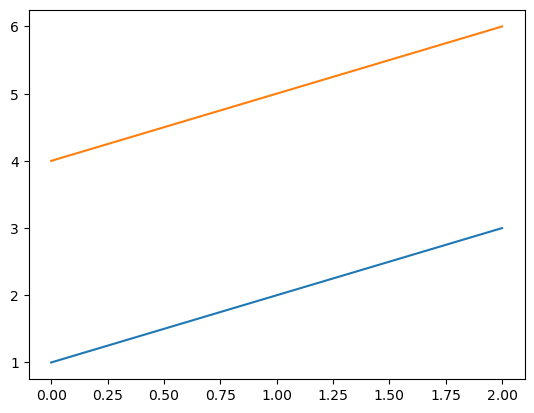

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([1,2,3])
plt.plot([4,5,6])

In [ ]:
# 8. 학습된 파라미터 확인 (Best 모델 로드)
model.load_state_dict(torch.load('best_model.pth'))
# print("\n학습된 파라미터 (Best Model):")

# 9. 예측 (선택 사항, Best 모델 사용)
with torch.no_grad():
    for inputs_test in test_loader:
        outputs_test = model(inputs_test)
        loss_test = criterion(outputs_test, inputs_test)
        test_loss += loss_test['loss'] * inputs_test.size(0)
test_loss /= len(X_test)
print(f"\n5.0에 대한 예측 (Best Model): {test_loss:.4f}")

plt.figure()
plt.plot(train_loss_lst)
plt.plot(val_loss_lst)

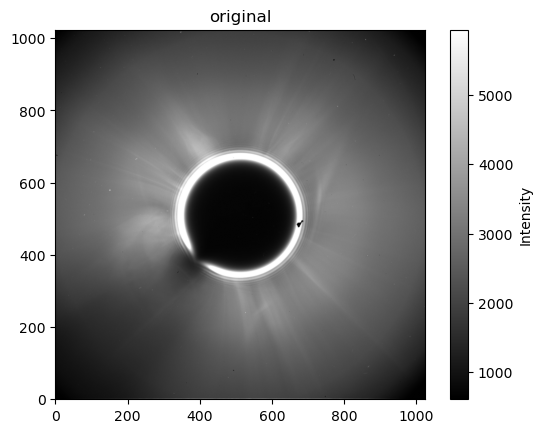

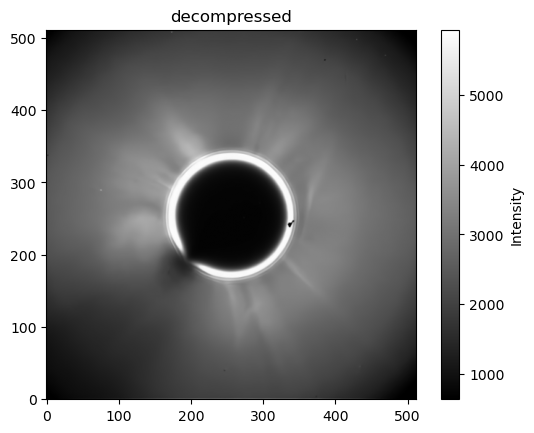

In [56]:
plt.figure()
plt.imshow(img_nosat, origin='lower', cmap = 'gray')
plt.title("original")
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)

plt.figure()
plt.imshow(x_final.cpu().detach().numpy(), origin='lower', cmap = 'gray')
plt.title("decompressed")
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# 1. 사용자 정의 Dataset 클래스 생성 (레이블 없음)
class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = [name for name in os.listdir(img_dir) if name.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image # 입력 이미지 자체를 타겟으로 사용

# 2. 데이터 경로 및 변환 정의
img_directory = 'path/to/your/unlabeled/image/directory' # 실제 레이블 없는 이미지 디렉토리 경로로 변경해주세요.
transform = transforms.Compose([
    transforms.Resize((128, 128)), # 오토인코더에 적합한 크기로 조정 (자유롭게 변경 가능)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Dataset 및 DataLoader 생성
image_dataset = UnlabeledImageDataset(img_directory, transform=transform)
batch_size = 16
train_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# 4. 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 32 -> 16
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.Tanh() # 출력을 -1과 1 사이로 조정 (정규화에 따라 변경 가능)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()

# 5. 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss() # 입력과 출력 이미지 간의 평균 제곱 오차
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 6. 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader): # 레이블은 사용하지 않으므로 _로 받음
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, images) # 입력 이미지를 타겟으로 사용

        # 역전파 및 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("학습 완료!")

In [ ]:
import argparse
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.transforms import Compose

import compressai.transforms as transforms

from compressai.datasets import ModelNetDataset
from compressai.losses import ChamferPccRateDistortionLoss
from compressai.optimizers import net_aux_optimizer
from compressai.registry import MODELS
from compressai.zoo import pointcloud_models


class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class CustomDataParallel(nn.DataParallel):
    """Custom DataParallel to access the module methods."""

    def __getattr__(self, key):
        try:
            return super().__getattr__(key)
        except AttributeError:
            return getattr(self.module, key)


def configure_optimizers(net, args):
    """Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers"""
    conf = {
        "net": {"type": "Adam", "lr": args.learning_rate},
        "aux": {"type": "Adam", "lr": args.aux_learning_rate},
    }
    optimizer = net_aux_optimizer(net, conf)
    return optimizer["net"], optimizer["aux"]


def train_one_epoch(
    model, criterion, train_dataloader, optimizer, aux_optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = {k: v.to(device) for k, v in d.items()}

        optimizer.zero_grad()
        aux_optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        aux_loss = model.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)} "
                f"({100. * i / len(train_dataloader):.0f}%)] "
                f'Loss: {out_criterion["loss"].item():.3f} | '
                f'Bpp loss: {out_criterion["bpp_loss"].item():.3f} | '
                f'Rec loss: {out_criterion["rec_loss"].item():.4f} | '
                # f'Aux loss: {aux_loss.item():.0f} | '
                "\n"
            )


def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    model.update(force=True, update_quantiles=True)
    device = next(model.parameters()).device

    meter_keys = ["loss", "bpp_loss", "rec_loss", "aux_loss"]
    meters = {key: AverageMeter() for key in meter_keys}

    with torch.no_grad():
        for d in test_dataloader:
            d = {k: v.to(device) for k, v in d.items()}

            out_net = model(d)
            out_criterion = criterion(out_net, d)
            out_criterion["aux_loss"] = model.aux_loss()

            for key in meters:
                if key in out_criterion:
                    meters[key].update(out_criterion[key])

    print(
        f"Test epoch {epoch}: Average losses: "
        f'Loss: {meters["loss"].avg:.3f} | '
        f'Bpp loss: {meters["bpp_loss"].avg:.3f} | '
        f'Rec loss: {meters["rec_loss"].avg:.4f} | '
        # f'Aux loss: {meters["aux_loss"].avg:.0f} | '
        "\n"
    )

    return meters["loss"].avg


def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")


def parse_args(argv):
    parser = argparse.ArgumentParser(description="Example training script.")
    parser.add_argument(
        "-m",
        "--model",
        default="sfu2023-pcc-rec-pointnet",
        choices=pointcloud_models.keys(),
        help="Model architecture (default: %(default)s)",
    )
    parser.add_argument(
        "-d", "--dataset", type=str, required=True, help="Training dataset"
    )
    parser.add_argument(
        "-e",
        "--epochs",
        default=100,
        type=int,
        help="Number of epochs (default: %(default)s)",
    )
    parser.add_argument(
        "-lr",
        "--learning-rate",
        default=1e-4,
        type=float,
        help="Learning rate (default: %(default)s)",
    )
    parser.add_argument(
        "-n",
        "--num-workers",
        type=int,
        default=4,
        help="Dataloaders threads (default: %(default)s)",
    )
    parser.add_argument(
        "--lambda",
        dest="lmbda",
        type=float,
        default=100,
        help="Bit-rate distortion parameter (default: %(default)s)",
    )
    parser.add_argument(
        "--batch-size", type=int, default=16, help="Batch size (default: %(default)s)"
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=64,
        help="Test batch size (default: %(default)s)",
    )
    parser.add_argument(
        "--aux-learning-rate",
        type=float,
        default=1e-3,
        help="Auxiliary loss learning rate (default: %(default)s)",
    )
    parser.add_argument(
        "--patch-size",
        type=int,
        nargs=2,
        default=(256, 256),
        help="Size of the patches to be cropped (default: %(default)s)",
    )
    parser.add_argument("--cuda", action="store_true", help="Use cuda")
    parser.add_argument(
        "--save", action="store_true", default=True, help="Save model to disk"
    )
    parser.add_argument("--seed", type=int, help="Set random seed for reproducibility")
    parser.add_argument(
        "--clip_max_norm",
        default=1.0,
        type=float,
        help="gradient clipping max norm (default: %(default)s",
    )
    parser.add_argument("--checkpoint", type=str, help="Path to a checkpoint")
    args = parser.parse_args(argv)
    return args


def main(argv):
    args = parse_args(argv)

    if args.seed is not None:
        print("no argv")
        return 0
        torch.manual_seed(args.seed)
        random.seed(args.seed)

    num_points = 1024

    train_dataset = ModelNetDataset(
        args.dataset,
        split="train",
        pre_transform=Compose(
            [
                transforms.ToDict(wrapper="torch_geometric.data.Data"),
                transforms.SamplePointsV2(
                    num=8192, remove_faces=True, include_normals=True, static_seed=1234
                ),
                transforms.NormalizeScaleV2(center=True, scale_method="l2"),
                transforms.ToDict(wrapper="dict"),
            ]
        ),
        transform=Compose(
            [
                transforms.ToDict(wrapper="torch_geometric.data.Data"),
                transforms.RandomSample(num=num_points, attrs=["pos", "normal"]),
                transforms.ToDict(wrapper="dict"),
            ]
        ),
    )

    test_dataset = ModelNetDataset(
        args.dataset,
        split="test",
        pre_transform=Compose(
            [
                transforms.ToDict(wrapper="torch_geometric.data.Data"),
                transforms.SamplePointsV2(
                    num=8192, remove_faces=True, include_normals=True, static_seed=1234
                ),
                transforms.NormalizeScaleV2(center=True, scale_method="l2"),
                transforms.ToDict(wrapper="dict"),
            ]
        ),
        transform=Compose(
            [
                transforms.ToDict(wrapper="torch_geometric.data.Data"),
                transforms.RandomSample(
                    num=num_points, attrs=["pos", "normal"], static_seed=1234
                ),
                transforms.ToDict(wrapper="dict"),
            ]
        ),
    )

    device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=True,
        pin_memory=(device == "cuda"),
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.test_batch_size,
        num_workers=args.num_workers,
        shuffle=False,
        pin_memory=(device == "cuda"),
    )

    net = MODELS[args.model]()
    net = net.to(device)

    if args.cuda and torch.cuda.device_count() > 1:
        net = CustomDataParallel(net)

    optimizer, aux_optimizer = configure_optimizers(net, args)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
    criterion = ChamferPccRateDistortionLoss(lmbda={"bpp": 1.0, "rec": args.lmbda})

    last_epoch = 0
    if args.checkpoint:  # load from previous checkpoint
        print("Loading", args.checkpoint)
        checkpoint = torch.load(args.checkpoint, map_location=device)
        last_epoch = checkpoint["epoch"] + 1
        net.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        aux_optimizer.load_state_dict(checkpoint["aux_optimizer"])
        lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

    best_loss = float("inf")
    for epoch in range(last_epoch, args.epochs):
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        train_one_epoch(
            net,
            criterion,
            train_dataloader,
            optimizer,
            aux_optimizer,
            epoch,
            args.clip_max_norm,
        )
        loss = test_epoch(epoch, test_dataloader, net, criterion)
        lr_scheduler.step(loss)

        is_best = loss < best_loss
        best_loss = min(loss, best_loss)

        if args.save:
            save_checkpoint(
                {
                    "epoch": epoch,
                    "state_dict": net.state_dict(),
                    "loss": loss,
                    "optimizer": optimizer.state_dict(),
                    "aux_optimizer": aux_optimizer.state_dict(),
                    "lr_scheduler": lr_scheduler.state_dict(),
                },
                is_best,
            )

# set hyperparameter
parser = argparse.ArgumentParser(description="train_1")

# 하이퍼파라미터
# 명령행 인수 파싱
args = parser.parse_args(['-m',''])


main(sys.argv[1:])
